In [ ]:
import pandas as pd;
import numpy  as np;

class CovidData:
    '''
    The CovidData Class creates objects that allow the user to retreive specific information from the daily updated COVID19 time series data made available from John Hopkins University
    '''
    def __init__(self):
        '''
        Constructor creates three dataframes that contain the original data of the global cases, deaths, and recoveries respectively
        '''
        self.cases_glob_df  = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
                                     error_bad_lines = False);
        self.deaths_glob_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv",
                                     error_bad_lines = False);
        self.recovs_glob_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv",
                                     error_bad_lines = False);

    def __anyDup(self, thelist):
        ''' 
        __anyDup is a private method that takes in a list and returns a set of duplicates that are contained in the list
        '''
        seen = set()
        dups = []
        for x in thelist:
            if x in seen:
                dups.append(x)
            seen.add(x)
        return set(dups);

    def __getDupCountries(self):
        '''
        __getDupCountries is a private method that returns all of the duplicate countries contained in the data
        '''
        countries = self.cases_glob_df;
        dup_countries = list( self.__anyDup(countries) );
        return dup_countries;

    def __sep_loc_dfs(self, location):
        '''
        __sep_loc_dfs is a private method that subsets the three original dataframes so that it only contains the location of interest
        '''
        cas_df = self.cases_glob_df.loc  [self.cases_glob_df  ['Country/Region'] == location];
        dea_df = self.deaths_glob_df.loc [self.deaths_glob_df ['Country/Region'] == location];
        rec_df = self.recovs_glob_df.loc [self.recovs_glob_df ['Country/Region'] == location];
        return cas_df, dea_df, rec_df

    def __trimDfByStartDate(self, df) :
        cols = list(df);
        count = 0;
        for col in cols:
            if df[col].sum() == 0:
                count +=1;
            else:
                break;
        if count == 0:
            return df;
        else:
            df = df.iloc[ : , count:]
            return df;

    def get(self, location = "Total"):
        '''
        the get method returns a dataframe that contains the total cases, deaths, and recovories every day for a location of interest.
        If no location is passed in, then the function will return a data frame that sums the cases, deaths, and recoveries of every country
        '''
        if location != "Total":            
            if location not in self.__getDupCountries():
                cas_df , dea_df , rec_df = self.__sep_loc_dfs(location);
                dates = list(cas_df.columns[4:]);
                dic = {};
                for date in dates:
                    dic[str(date)] = [(list(cas_df[date])[0]) , (list(dea_df[date])[0]) , (list(rec_df[date])[0])];
                df = pd.DataFrame.from_dict(dic)
                df = self.__trimDfByStartDate(df);
                df = df.transpose();
                df.columns = ['Cases','Deaths','Recoveries'];

            else:
                # In case country has multiple provincies, just sum it up
                cas_df , dea_df , rec_df = self.__sep_loc_dfs(location);
                dates = list(self.cas_df.columns[4:]);
                dic = {};
                for date in dates:
                    dic[str(date)] = [(self.cas_df[date].sum()) ,(self.dea_df[date].sum()) , (self.rec_df[date].sum())]
                df = pd.DataFrame.from_dict(dic)
                df = self.__trimDfByStartDate(df);
                df = df.transpose();
                df.columns = ['Cases','Deaths','Recoveries'];
        else:
            dates = list(self.cases_glob_df.columns[4:]);
            dic = {};
            for date in dates:
                dic[str(date)] = [(self.cases_glob_df[date].sum()) ,(self.deaths_glob_df[date].sum()) , (self.recovs_glob_df[date].sum())]
            df = pd.DataFrame.from_dict(dic).transpose();
            df.columns = ['Cases','Deaths','Recoveries'];
        return df;

    def getSIRD_df(self, location = "Total", population = 7800000000):
        '''
        the getSIR_df method returns a dataframe that contains S I R values every day for a location of interest.
        If no location is passed in, then the function will return a data frame that sums the S I R values for every country
        '''
        loc_df = self.get(location);
        
        #loc_df['SIR_Suceptible'] = (population - (loc_df['Cases'] - loc_df['Deaths'] - loc_df['Recoveries']));
        #loc_df['SIR_Infected']   = (loc_df['Cases'] - loc_df['Deaths'] - loc_df['Recoveries']);
        #loc_df['SIR_Recovered']  = (loc_df['Recoveries']);

        loc_df['SIR_Suceptible'] = (population - (loc_df['Cases']))
        loc_df['SIR_Infected']   = (loc_df['Cases'] - loc_df['Deaths'] - loc_df['Recoveries']);
        loc_df['SIR_Recovered']  = (loc_df['Recoveries'])
        loc_df['SIR_Deaths']     = loc_df['Deaths'];
        
        #SIR_df = loc_df.loc[:, loc_df.columns.intersection(['SIR_Suceptible','SIR_Infected','SIR_Recovered' ])];
        SIR_df = loc_df.loc[:, loc_df.columns.intersection(['SIR_Suceptible','SIR_Infected','SIR_Recovered', 'SIR_Deaths' ])];

        return SIR_df;

    def get_closed_active_cases_df(self, location):
        loc_df = self.get(location);
        loc_df['Closed Cases'] = loc_df['Deaths']    + loc_df['Recovered'];
        loc_df['Active Cases'] = loc_df['Confirmed'] - loc_df['Closed Cases'];
        active_closed_df = loc_df.loc[:, loc_df.columns.intersection(['Active Cases','Closed Cases'])];
        return active_closed_df;



In [ ]:
import pandas as pd;
import numpy  as np;
import matplotlib.pyplot as plt;
import scipy.integrate; 

class SIRD_plots:
    def __init__(self, country, population, beta, gamma, mu, s0, i0, r0, d0, SIR_df = None):
        '''
        SIR_plots constructor. Takes in the name of the country, population, 
        beta value, gamma value, inital SIR conditions, and an SIR dataframe
        to display plots to analyze the SIR model
        '''
        self.country = country;
        self.pop = population;
        self.beta = beta;
        self.gamma = gamma;
        self.mu    = mu
        self.s0 = s0;
        self.i0 = i0;
        self.r0 = r0;
        self.d0 = d0;
        self.df = SIR_df;

    def __SIRD_model (self, y, t, beta, gamma, mu):
        '''
        __SIR_model is a private method that computes the
        SIR differentials
        '''
        S, I, R, D = y;
        dS_dt   = (-beta*S*I)/self.pop;
        dI_dt   = (((beta*S*I)/self.pop) - (gamma*I)) - (mu*I)
        dR_dt   = (gamma*I);
        dD_dt   = (mu*I)
        return    ([ dS_dt , dI_dt , dR_dt, dD_dt ]);

    def __init_plots(self):
        '''
        ___init_plots is a private method that is used to
        adjust the plots so that they are all dark mode and 
        the same size
        '''
        plt.style.use("dark_background");
        plt.figure(figsize = [7,5]);

    def __plot_details(self, title, x, y):
        '''
        __plot_details is a private method that makes it easy to 
        set the title, axis labels and other plot things for all
        of the figures
        '''
        plt.title (self.country + " " + title , size = 25);
        plt.xlabel(x , size = 16);
        plt.ylabel(y , size = 16);
        plt.legend(prop = {'size' : 20});
        plt.show();

    def plot_SIRD_model (self, time):
        '''
        plot_SIR_model calls SIR_model and forms a solution vector of integrated values. It will then plot the solution.
        A timeframe needs to be passed in.
        '''
        t = np.linspace(1,time,10000);
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution);
    
        self.__init_plots();
    
        plt.plot(t , solution[:, 0]/self.pop , label = "S(t)" , color = 'orange');
        plt.plot(t , solution[:, 1]/self.pop , label = "I (t)" , color = 'indianred');
        plt.plot(t , solution[:, 2]/self.pop , label = "R (t)" , color = 'cyan');
        plt.plot(t , solution[:, 3]/self.pop , label = "D (t)" , color = 'Crimson');

        self.__plot_details("SIR Model " + str(time) + " Days" , "Time", "Proportion");

    def plot_SIRD_values (self):
        '''
        plot_SIR_values plots SIR values of the data provided in the constructor
        '''
        t = np.linspace(1,len(self.df.index),10000);
        self.__init_plots();
    
        #plt.plot(self.df['SIR_Suceptible'], label = "Suceptible Plot", color = 'yellow');
        plt.plot(self.df['SIR_Infected'],   label = "Infected Plot"  , color = 'crimson');
        plt.plot(self.df['SIR_Recovered'],  label = "Recovered Plot" , color = 'limegreen');
        plt.plot(self.df['SIR_Deaths'],     label = "Death Plot"     , color = 'indianred');
    
        self.__plot_details("SIR Values Plot", "Time", "Counts");

    def modelValueComparison (self):
        '''
        plot_SIR_plot_and_model compared an SIR_model with the SIR values provided in the constructor
        '''

        t = np.linspace(1,time,10000);
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution);

        self.__init_plots();
    
        #plt.plot(t , solution[:, 0] , label = "S(t)" , color = 'orange');
        plt.plot(t , solution[:, 1] , label = "I(t)" , color = 'indianred');
        plt.plot(t , solution[:, 2] , label = "R(t)" , color = 'cyan');
        plt.plot(t , solution[:, 3] , label = "D(t)" , color = 'crimson');
    
        #plt.plot(self.df['SIR_Suceptible'], label = "Suceptible Plot", color = 'yellow');
        plt.plot(self.df['SIR_Infected'] ,  label = "Infected Plot"  , color = 'crimson');
        plt.plot(self.df['SIR_Recovered'] , label = "Recovered Plot" , color = 'limegreen');
        plt.plot(self.df['SIR_Deaths']    , label = "Deaths Plot"    , color = 'indianred');
    
        self.__plot_details("SIR Model and Values Plot", "Time", "Counts");

    def S_Comparison (self):
        '''
        S_Comparison plots the suceptible curve against the Suceptible values.
        '''
        time = self.df.shape[0]
        t = np.linspace(1,time,10000);
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution);
        self.__init_plots();
    
        plt.plot(t , solution[:, 0] , label = "S(t)" , color = 'orange');
        plt.plot(self.df['SIR_Suceptible'], label = "Suceptible Plot", color = 'yellow');
        self.__plot_details("S Comparison", "Time", "Counts");

    def S_ComparisonTrain (self, trainX):
        '''
        S_Comparison plots the suceptible curve against the Suceptible values.
        '''
        time = self.df.shape[0]
        t = np.linspace(1,time,10000);
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution);
        self.__init_plots();
    
        plt.plot(t , solution[:, 0] , label = "S(t)" , color = 'orange');
        plt.plot(self.df['SIR_Suceptible'], label = "Suceptible Plot", color = 'yellow');
        
        plt.plot(trainX['SIR_Suceptible'], label = "Training Set", color = 'white');

        self.__plot_details("S Comparison", "Time", "Counts");

    def I_Comparison (self):
        '''
        I_Comparison plots the infected curve against the infected values.
        '''
        time = self.df.shape[0]
        t = np.linspace(1,time,10000);
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution);
        self.__init_plots();

        plt.plot(t , solution[:, 1] , label = "I(t)" , color = 'indianred');
        plt.plot(self.df['SIR_Infected'] , label = "Infected Plot"  , color = 'crimson');

        self.__plot_details("I Comparison", "Time", "Counts");

    def I_ComparisonTrain (self, trainX):
        '''
        I_Comparison plots the infected curve against the infected values.
        '''
        time = self.df.shape[0]
        t = np.linspace(1,time,10000);
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution);
        self.__init_plots();

        plt.plot(t , solution[:, 1] , label = "I(t)" , color = 'indianred');
        plt.plot(self.df['SIR_Infected'] , label = "Infected Plot"  , color = 'crimson');
        plt.plot(trainX['SIR_Infected'], label = "Training Set", color = 'white');

        self.__plot_details("I Comparison", "Time", "Counts");

    def R_Comparison (self):
        '''
        R_Comparison plots the recovered curve against the recovered values.
        '''
        time = self.df.shape[0]
        t = np.linspace(1,time,10000);
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution);
    
        plt.plot(t , solution[:, 2] , label = "R(t)" , color = 'cyan');
        plt.plot(self.df['SIR_Recovered'] , label = "Recovered Plot" , color = 'limegreen');
    
        self.__plot_details("R Comparison", "Time", "Counts");

    def D_Comparison (self):
        '''
        R_Comparison plots the recovered curve against the recovered values.
        '''
        time = self.df.shape[0]
        t = np.linspace(1,time,10000);
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution);
    
        plt.plot(t , solution[:, 3] , label = "D(t)" , color = 'indianred');
        plt.plot(self.df['SIR_Deaths'] , label = "Deaths Plot" , color = 'crimson');
    
        self.__plot_details("D Comparison", "Time", "Counts");

    def R_ComparisonTrain (self, trainX):
        '''
        R_Comparison plots the recovered curve against the recovered values.
        '''
        time = self.df.shape[0]
        t = np.linspace(1,time,10000);
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution);
    
        plt.plot(t , solution[:, 2] , label = "R(t)" , color = 'cyan');
        plt.plot(self.df['SIR_Recovered'] , label = "Recovered Plot" , color = 'limegreen');
        plt.plot(trainX['SIR_Recovered'], label = "Training Set", color = 'white');
    
        self.__plot_details("R Comparison", "Time", "Counts");

    def D_ComparisonTrain (self, trainX):
        '''
        R_Comparison plots the recovered curve against the recovered values.
        '''
        time = self.df.shape[0]
        t = np.linspace(1,time,10000);
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution);
    
        plt.plot(t , solution[:, 3] , label = "D(t)" , color = 'indianred');
        plt.plot(self.df['SIR_Deaths'] , label = "Deaths Plot" , color = 'crimson');
        plt.plot(trainX['SIR_Deaths'], label = "Training Set", color = 'white');
    
        self.__plot_details("D Comparison", "Time", "Counts");

In [ ]:
import pandas as pd;
import numpy  as np;

import matplotlib.pyplot as plt;
import scipy.integrate; 
from   scipy.integrate import solve_ivp
from   scipy.optimize  import minimize, differential_evolution

import copy;

from sklearn.model_selection import train_test_split, RandomizedSearchCV;
from sklearn.preprocessing   import PolynomialFeatures;
from sklearn.linear_model    import BayesianRidge;

def SIRD_model (y, t, beta, gamma, mu, pop):
    S, I, R, D = y;
    dS_dt   = (-beta*S*I)/pop;
    dI_dt   = (((beta*S*I)/pop) - (gamma*I)) - (mu*I)
    dR_dt   = (gamma*I);
    dD_dt   = (mu*I)
    return    ([ dS_dt , dI_dt , dR_dt, dD_dt ]);

def get_SIRD_initials (SIR_df):
    '''
    get_SIR_initials retrieves the inital S I R values from a time series dataframe
    Parameters: 
    \t1) SIR_df is a timeseries dataframe that contains S I R values
    '''
    SIR_0 = list(SIR_df.iloc[0 , :]);
    SIR_0 = [SIR_0[0],1,0,0]
    return SIR_0[0] , SIR_0[1], SIR_0[2], SIR_0[3]

def betaGamaMuMinimization(point, data, s0, i0, r0, d0, pop):
    '''
    The betaGamaMuMinimization function was written to be minimized based on the RMSE between 
    \t- the Calculated Infected cases and the Estimated Infected cases with the given Beta and Gamma.
    \t- the Actual Recovered cases and the Estimated Recovered cases with the given Beta and Gamma.
    '''
    beta, gamma, mu = point
    size = len(data)
    
    def SIRD(t,y):
        S = y[0]
        I = y[1]
        R = y[2]
        D = y[3]
        return [(-beta*S*I/pop), (beta*S*I/pop) - gamma*I - mu*I,gamma*I, mu*I]

    solution = solve_ivp(SIRD, [0, size], [s0, i0, r0, d0], t_eval = np.arange(0, size, 1), vectorized=True);
    
    l0 = np.sqrt(np.mean((solution.y[0] - data['SIR_Suceptible'])**2));
    l1 = np.sqrt(np.mean((solution.y[1] - data['SIR_Infected'  ])**2));
    l2 = np.sqrt(np.mean((solution.y[2] - data['SIR_Recovered' ])**2));
    l3 = np.sqrt(np.mean((solution.y[3] - data['SIR_Deaths'    ])**2));
    
    # Put more emphasis on infected people
    a = .20
    b = .25
    c = .25
    d = .25
    return (a * l0) + (b * l1) + (c * l2) + (d * l3)

def trainSIRD(countrySIRdf, population, s0, i0, r0, d0):
    # Local min
    optimal = minimize(betaGamaMuMinimization,[0.001, 0.001, 0.001], args = (countrySIRdf, s0, i0, r0,d0, population), method = 'L-BFGS-B', bounds = [(0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4)])
    # Global Min
    #optimal = differential_evolution(betaGamaMuMinimization,bounds = [(0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4)], args = (countrySIRdf, s0, i0, r0,d0, population), strategy = 'best1bin')
    beta , gamma, mu = optimal.x;
    return beta , gamma, mu

def setDaysSinceIndex (df):
    dateList = list(df.index);
    days = int(df.shape[0])
    daysSinceLst = [];
    count = 0;
    for i in range(days):
        count+=1;
        daysSinceLst.append(count);
    df = df.set_index(pd.Index(daysSinceLst));
    return df;

def polyBayRidgePredicter (X_train, y, y_train, y_test) :
    tol      = [1e-4, 1e-3, 1e-2];
    alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4];
    alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4];
    lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4];
    lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4];

    bayesian_grid = {'tol'     : tol,
                     'alpha_1' : alpha_1,
                     'alpha_2' : alpha_2,
                     'lambda_1': lambda_1,
                     'lambda_2': lambda_2 }

    poly         = PolynomialFeatures(degree=5);
    poly_y_train = poly.fit_transform(y_train);
    poly_y_test  = poly.fit_transform(y_test);
    poly_y       = poly.fit_transform(y);

    bayesian = BayesianRidge(fit_intercept=False, normalize=True);
    bayesian_search_poly = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
    bayesian_search_poly.fit(poly_y_train, X_train);
    print(bayesian_search_poly.best_params_);
    
    bayesian_poly_confirmed = bayesian_search_poly.best_estimator_
    test_poly_bayesian_pred = bayesian_poly_confirmed.predict(poly_y_test)
    bayesian_poly_pred      = bayesian_poly_confirmed.predict(poly_y)

    return bayesian_poly_pred;

def plotPolyBayRidgePrediction(X, y, X_train, y_train, bayesian_poly_pred) :
    plt.style.use("dark_background");
    plt.figure(figsize=(15, 10))
    plt.plot(y,
             X,
             label = 'Actual Future Infections',
             color = 'crimson')
    plt.plot(y,
             bayesian_poly_pred,
             label = 'Ridge Polynomial Prediction of Future Infections',
             linestyle = "dashed",
             color = 'gold')
    plt.plot(y_train,
             X_train,
             label = 'Training Set',
             color = 'lightgrey')

    plt.title('Polynomial Bayesian Ridge Regression Prediciton of Infected Population', size=30)
    plt.xlabel('Days Since', size = 30)
    plt.ylabel('# of Infections', size = 30)
    #plt.grid()
    plt.legend(prop = {'size' : 15});
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

def plotRidgeAndSIRPrediction(X, y, X_train, y_train, bayesian_poly_pred, solution, pop) :
    plt.style.use("dark_background");
    plt.figure(figsize=(10, 10))
    plt.plot(y,
             X,
             label = 'Actual Future Infections',
             color = 'crimson')
    plt.plot(y,
             bayesian_poly_pred,
             label = 'Ridge Polynomial Prediction of Future Infections',
             linestyle = "dashed",
             color = 'gold')
    
    time = len(X)
    t = np.linspace(1,time,10000);
    plt.plot(t , solution[:, 1] , label = "SIRD I(t) Prediction" , color = 'cyan');

    plt.plot(y_train,
             X_train,
             label = 'Training Set',
             color = 'lightgrey')

    plt.title('Prediction Comparison of Infected Population', size=35)
    plt.xlabel('Days Since', size = 30)
    plt.ylabel('# of Infections', size = 30)
    #plt.grid()
    plt.legend(prop = {'size' : 25});
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.show()

def predictSIRD(df, beta , gamma, mu, s0, i0, r0, d0, pop) :
    time = df.shape[0]
    t = np.linspace(1,time,10000);
    solution = scipy.integrate.odeint(SIRD_model, [s0, i0, r0, d0], t, args = (beta, gamma, mu, pop))
    solution = np.array(solution);
    return solution;

def trainTestSplitDataFrame (df, trainSize):
    nRows = df.shape[0]
    nTrainRows = nRows*trainSize//100
    nTestRows = nRows - nTrainRows
    trainDf = df.iloc[:nTrainRows , :]
    testDf  = df.iloc[nTrainRows: , :]
    return trainDf , testDf

def analyzeSIRDtraining(country, pop, trainSize):
    data = CovidData();
    df = data.getSIRD_df(country, pop);
    df =df.iloc[ :110 , :]
    df = setDaysSinceIndex(df);
    s0, i0, r0, d0 = get_SIRD_initials(df)
    trainDf , testDf = trainTestSplitDataFrame(df, trainSize)
    beta , gamma, mu = trainSIRD(trainDf, pop, s0, i0, r0, d0);
    solution = predictSIRD(df, beta , gamma, mu, s0, i0, r0, d0, pop)
    
    country_plots = SIRD_plots(country, pop, beta, gamma, mu, s0, i0, r0, d0, df);
    country_plots.S_ComparisonTrain(trainDf);
    country_plots.I_ComparisonTrain(trainDf);
    country_plots.R_ComparisonTrain(trainDf);
    country_plots.D_ComparisonTrain(trainDf);
    country_plots.plot_SIRD_model(365);

    X = np.array(df["SIR_Infected"]);
    
    y = np.array(df.index).reshape(-1,1);
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ((100 - trainSize)/100), shuffle = False);
    bayesian_poly_pred = polyBayRidgePredicter(X_train, y, y_train, y_test)
    plotPolyBayRidgePrediction(X, y, X_train, y_train, bayesian_poly_pred)
    plotRidgeAndSIRPrediction(X, y, X_train, y_train, bayesian_poly_pred, solution, pop)
    
    return beta, gamma, mu

def main():
    
    #japan_pop = 126.5*(10**6);
    #us_pop    = 328.2*(10**6);
    #italy_pop = 60.36*(10**6);
    

    japan_pop = 16000;
    us_pop = 1400000
    #beta, gamma, mu = analyzeSIRDtraining("US", us_pop,99)
    analyzeSIRDtraining("Japan", japan_pop, 95)
    

main();

# **0. Dependencies**

In [1]:
import numpy as np

# **1. SIRD Model**

The COVID-19 infectious disease is an epidemic. To model an epidemic, suitable groups (also known as compartments) are defined to cover the entire population of a country. The population **N** is assumed to be constant because:
+ The epidemic has a (relatively) short time scale, for which the new births can be neglected.
+ The number of deaths is small as compared with the entire population
+ Travel restrictions are enforced.

The population N is divided into mutually exclusive groups: susceptible (**S**), infected (**I**), deceased (**D**), and recovered (**R**) as below:
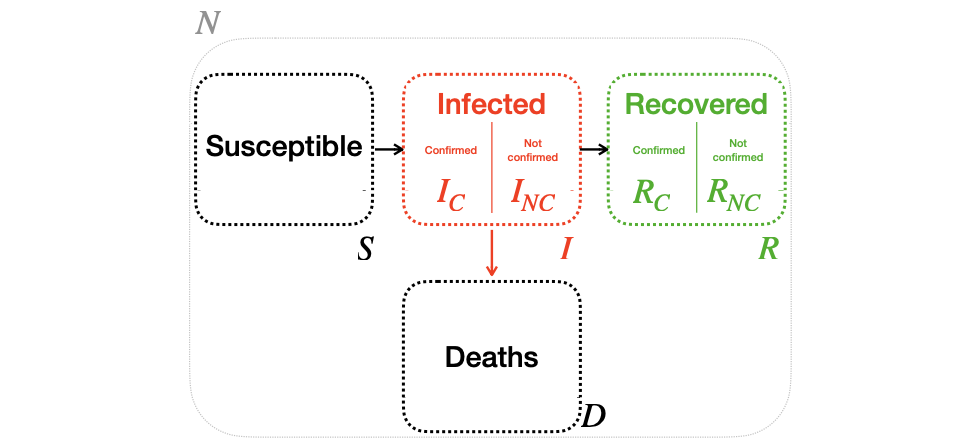

In this model, the deaths are due to COVID-19. Every group is assumed to have the same characteristics, i.e., the groups are homogeneous. Every susceptible person can contract the virus (the immune group is neglected). Mathematically, the population N, which does not vary in time, is the sum of the groups S, I, R, D, which vary in time.
```
N = S + R + I + D
```
With the assumptions, SIRD model are expressed by four ordinary differential equations (ODEs) with time-varying parameters (non-autonomous dynamical system)
```
dS/dt = -beta*(I/N)*S
dI/dt = beta*(I/N)*S - (gamma+mu)*I
dR/dt = gamma*I
dD/dt = mu*I
```
subject to initial conditions `S0`, `I0`, `R0`, `D0`. In compact form,
```
dq/dt = F(q, alpha)
q = q0 at t=0
```
Where `F` is the model (i.e., the SIRD equations), and `q` and `alpha` are the column vectors of the state and parameters, respectively.
```
q: [S; I; R; D]
alpha: [beta; gamma; mu]
```


In [ ]:
class SIRD:
  def __init__(q0, alpha):
    self.q0 = q0
    self
    self.alpha = alpha

  def differential(q, alpha):
    S, I, R, D = q;
    N = S + I + R + D
    beta, gamma, mu = alpha
    dS_dt = (-beta*S*I)/N
    dR_dt = gamma*I
    dD_dt = mu*I
    dI_dt = -dS_dt - dR_dt - dI_dt
    return [dS_dt , dI_dt , dR_dt, dD_dt];

  def predict()

# **2. Prepare Data**

# **3. Visualize Data**

# **4. Training**

# **5. Evaluation**